In [1196]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

import os
import glob
import ast
import matplotlib

import numpy as np
from scipy.optimize import curve_fit

In [1197]:
n_lines = len(all_before_avg)
cmap = matplotlib.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

In [1198]:
def sine_function(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [1199]:
# measurements folder path
folder_path = "measurements\\measurements_after_HWP_fm2\\"
folder_path = "measurements/measurements_after_HWP_fm2/"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
csv_files

['measurements/measurements_after_HWP_fm2\\measured_darkcount.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf01.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf012.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf02.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf03.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf04.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf05_06_N48_blackmeasurement_nosleep.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf06.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf07.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf08.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf09.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf10.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf10_02.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf15.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf20.csv',
 'measurements

In [1200]:
# before hwp folder path
folder_path = "analog_data/before_hwp/"
analog_files =  glob.glob(os.path.join(folder_path, "*.csv"))
analog_files

['analog_data/before_hwp\\powers_fm2_darkcount.csv',
 'analog_data/before_hwp\\powers_fm2_rf_01.csv',
 'analog_data/before_hwp\\powers_fm2_rf_100.csv',
 'analog_data/before_hwp\\powers_fm2_rf_15.csv',
 'analog_data/before_hwp\\powers_fm2_rf_2.csv',
 'analog_data/before_hwp\\powers_fm2_rf_20.csv',
 'analog_data/before_hwp\\powers_fm2_rf_25.csv',
 'analog_data/before_hwp\\powers_fm2_rf_3.csv',
 'analog_data/before_hwp\\powers_fm2_rf_30.csv',
 'analog_data/before_hwp\\powers_fm2_rf_35.csv',
 'analog_data/before_hwp\\powers_fm2_rf_4.csv',
 'analog_data/before_hwp\\powers_fm2_rf_40.csv',
 'analog_data/before_hwp\\powers_fm2_rf_45.csv',
 'analog_data/before_hwp\\powers_fm2_rf_5.csv',
 'analog_data/before_hwp\\powers_fm2_rf_50.csv',
 'analog_data/before_hwp\\powers_fm2_rf_55.csv',
 'analog_data/before_hwp\\powers_fm2_rf_6.csv',
 'analog_data/before_hwp\\powers_fm2_rf_60.csv',
 'analog_data/before_hwp\\powers_fm2_rf_65.csv',
 'analog_data/before_hwp\\powers_fm2_rf_7.csv',
 'analog_data/before_

In [1201]:
#read in darkcounts
darkcounts = pd.read_csv(csv_files[0])
darkcounts_before = pd.read_csv(analog_files[0], skiprows=2)


In [1202]:
# save all for all measured rfs the loaded df into a list
all_rf = [pd.read_csv(file) for file in csv_files[1:]]
all_before = [pd.read_csv(file, skiprows=2) for file in analog_files[1:]]


In [1203]:
#initiate dicts for saving before avgs
all_before_dict = {}
all_before_avg = {}

In [1204]:
for i, data in enumerate(all_before):
    rf = os.path.basename(analog_files[i+1]).split('rf_')[1][0:3]
    rf = rf.split('.')[0]
    label = f'rf{rf}'
    print(i, label)
    all_before_dict[label] = data
    all_before_avg[label] = np.average(all_before_dict[label][' Measurement'])



0 rf01
1 rf100
2 rf15
3 rf2
4 rf20
5 rf25
6 rf3
7 rf30
8 rf35
9 rf4
10 rf40
11 rf45
12 rf5
13 rf50
14 rf55
15 rf6
16 rf60
17 rf65
18 rf7
19 rf70
20 rf75
21 rf78
22 rf8
23 rf80
24 rf83
25 rf85
26 rf88
27 rf9
28 rf90
29 rf92
30 rf94
31 rf96
32 rf98


In [1205]:
# chanigning keys for before hwp so theyre consistent
keys = all_before_avg.keys()
print(keys)
for key in keys:
    if len(key) == 3:
        newkey = 'rf0' + key.split('rf')[1]
        all_before_avg[newkey] = all_before_avg.pop(key)

dict_keys(['rf01', 'rf100', 'rf15', 'rf2', 'rf20', 'rf25', 'rf3', 'rf30', 'rf35', 'rf4', 'rf40', 'rf45', 'rf5', 'rf50', 'rf55', 'rf6', 'rf60', 'rf65', 'rf7', 'rf70', 'rf75', 'rf78', 'rf8', 'rf80', 'rf83', 'rf85', 'rf88', 'rf9', 'rf90', 'rf92', 'rf94', 'rf96', 'rf98'])


RuntimeError: dictionary keys changed during iteration

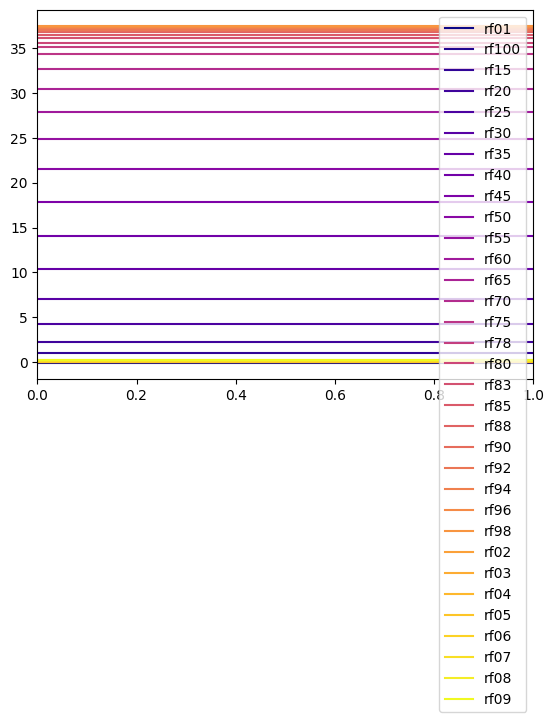

In [709]:
for i, (rf, avg) in enumerate(all_before_avg.items()):
    # print(rf, avg)
    plt.axhline(avg, label=rf, color = colors[i])
    plt.legend()

Text(0, 0.5, 'Power before HWP [W]')

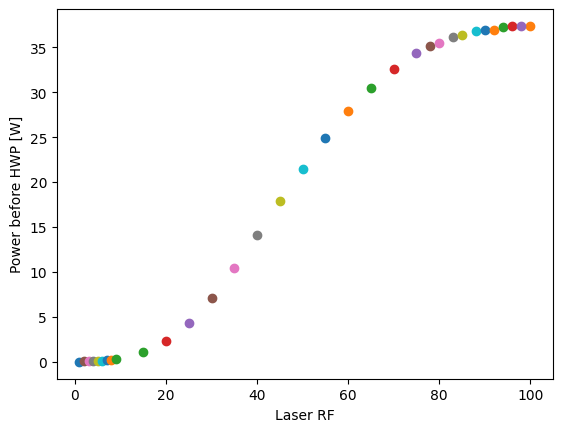

In [1005]:
for i, (rf, avg) in enumerate(all_before_avg.items()):
    # print(rf, avg)
    # plt.axhline(avg, label=rf, color = colors[i])
    # plt.legend()
    plt.scatter(int(rf[2:]), avg)
plt.xlabel('Laser RF')
plt.ylabel('Power before HWP [W]')

hello ! | 
hello ! | 


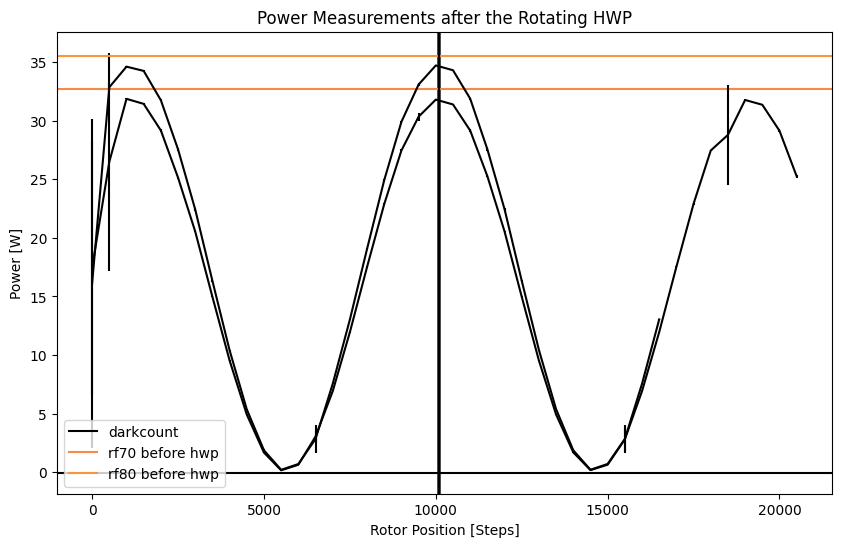

In [1206]:
# plot all rfs tgt

fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')

#darkcount line
ax.axhline(np.average(darkcounts['averaged']), color = 'black', label = 'darkcount')
#before hwp average

for i, data in enumerate(all_rf):
    x = np.zeros(len(data['rotor_step']), dtype=float)
    for j,step in enumerate(data['rotor_step']):
        lst = ast.literal_eval(step)
        array = np.array(lst, dtype=float)
        x[j] = array[0]
    rf = os.path.basename(csv_files[i+1]).split('rf')[1][0:2]
    # rf = os.path.basename(csv_files[i+1]).split('rf')[1]
    label = f'rf{rf}'

    # if 'N48' in os.path.basename(csv_files[i+1]) or '03' in os.path.basename(csv_files[i+1]):
    # if (rf == '15') or (rf=='10'):
    if i > 22:
        print('hello ! | ')
        y = data['averaged']
        error = np.array(data['stdev'])

        # params, params_covariance = curve_fit(sine_function, x[3:], y[3:], p0 = [0.0361029908,0.0998, 3.87, 0.0046])
        # plt.plot(x, sine_function(x, *params), label='Fitted Sine Function', color='red')
        # print(i, "Fitted Parameters: A = {}, B = {}, C = {}, D = {}".format(*params))
        try:
            ax.axhline(all_before_avg[label], color = colors[i], label = f'{label} before hwp')
        except KeyError:
            print(f'{label} isnt measured at before hwp')
        # ax.scatter(x, y, label=label, marker='x')
        # ax.plot(x, y, label=label, color = colors[i])
        ax.errorbar(x = x, y = y, yerr=error, fmt='-o', color = 'black', markersize = 0)
    ax.axvline(10000+100, color = 'black')
    
ax.legend()